# Claims Analysis

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [21]:
import operator
import math
import random
import itertools
from collections import Counter
import json as j
from gb.hypergraph.hypergraph import HyperGraph
import gb.hypergraph.symbol as sym
import gb.hypergraph.edge as ed
import gb.nlp.parser as par
import gb.tools.json as json_tools
from gb.synonyms.meronomy import Meronomy
from gb.metrics.hyper_similarity import HyperSimilarity

import numpy as np
import matplotlib.pyplot as plt

from visJS2jupyter import visJS_module
from visJS2jupyter import visualizations
import networkx as nx

### Constants

In [3]:
MAX_PROB = -12

### HyperGraph

In [4]:
hg = HyperGraph({'backend': 'leveldb', 'hg': '../reddit-worldnews-01012013-01082017.hg'})

### Start parser

In [5]:
parser = par.Parser()

### Aux Functions

In [6]:
def rel_contains(full_edge, term):
    if sym.is_edge(full_edge) and len(full_edge) > 2 and sym.is_edge(full_edge[2]):
        rel = full_edge[0]
        if sym.is_edge(rel):
            return term in rel
        else:
            return rel == term
    return False


def edge2str(edge):
    s = ed.edge2str(edge, namespaces=False)
    if sym.is_edge(edge):
        return s

    if s[0] == '+':
        s = s[1:]

    if len(s) == 0:
        return None

    if not s[0].isalnum():
        return None

    word = parser.make_word(s)
    if word.prob < MAX_PROB:
        return s

    return None


def edge2syn(edge):
    atom = edge2str(edge)
    if atom:
        syn_id = mer.syn_id(atom)
        if syn_id:
            return syn_id
    return None

### Meronomy and Say Edges

In [7]:
mer = Meronomy(parser)

edge_data = json_tools.read('../reddit-worldnews-01012013-01082017-edges.json')

say_edges = []
for it in edge_data:
    edge_ns = ed.str2edge(it['edge'])
    mer.add_edge(edge_ns)
    edge = ed.without_namespaces(edge_ns)
    
    # (says x ...)
    if rel_contains(edge, 'says'):
        say_edges.append(edge)
        
mer.generate()

In [27]:
preds = Counter()

for it in edge_data:
    edge_ns = ed.str2edge(it['edge'])
    # edge = ed.without_namespaces(edge_ns)
    if sym.is_edge(edge_ns):
        pred = ed.edge2str(edge_ns[0])
        preds[pred] += 1

In [39]:
print(preds.most_common(100))

[('has_label/gb', 1816093), ('+/gb', 1813382), ('says/nlp.say.verb', 12250), ('is/nlp.be.verb', 6045), ('to/nlp.to.part', 4109), ('said/nlp.say.verb', 3523), ('killed/nlp.kill.verb', 3465), ('kills/nlp.kill.verb', 3147), ('say/nlp.say.verb', 2913), ('warns/nlp.warn.verb', 2264), ('calls/nlp.call.verb', 1841), ('are/nlp.be.verb', 1775), ('found/nlp.find.verb', 1759), ('kill/nlp.kill.verb', 1601), ('was/nlp.be.verb', 1401), ('has/nlp.have.verb', 1346), ('arrested/nlp.arrest.verb', 1299), ('hits/nlp.hit.verb', 1103), ('finds/nlp.find.verb', 1082), ('urges/nlp.urge.verb', 1073), ('shows/nlp.show.verb', 1065), ('dies/nlp.die.verb', 1055), ('rejects/nlp.reject.verb', 1008), ('accuses/nlp.accuse.verb', 982), ('faces/nlp.face.verb', 976), ('tells/nlp.tell.verb', 954), ('threatens/nlp.threaten.verb', 940), ('claims/nlp.claim.verb', 929), ('gets/nlp.get.verb', 925), ('wants/nlp.want.verb', 918), ('seeks/nlp.seek.verb', 913), ('takes/nlp.take.verb', 894), ('makes/nlp.make.verb', 849), ('hit/nlp.h

In [62]:
x = hg.pattern2edges(['opens/nlp.open.verb', None, None])
x

{('opens/nlp.open.verb',
  'russia/nlp.russia.noun',
  ('+/gb',
   'criminal/nlp.criminal.adj',
   'case/nlp.case.noun',
   ('+/gb', 'against/nlp.against.adp', 'us/nlp.us.pron'),
   ('+/gb',
    'band/nlp.band.noun',
    ('+/gb', 'bloodhound/nlp.bloodhound.noun', 'gang/nlp.gang.noun')))),
 ('opens/nlp.open.verb',
  ('+/gb', 'turkish/nlp.turkish.adj', 'tunnel/nlp.tunnel.noun'),
  ('+/gb',
   'first/nlp.first.adj',
   ('+/gb',
    'undersea/nlp.undersea.adj',
    ('+/gb',
     'between/nlp.between.adp',
     'link/nlp.link.noun',
     ('+/gb', 'two/nlp.two.num', 'continents/nlp.continent.noun'))))),
 ('opens/nlp.open.verb',
  'berlin/nlp.berlin.noun',
  ('+/gb',
   'first/nlp.first.adj',
   ('+/gb',
    'lgbt/nlp.lgbt.adj',
    ('+/gb', 'refugee/nlp.refugee.noun', 'center/nlp.center.noun')))),
 ('opens/nlp.open.verb',
  'microsoft/nlp.microsoft.noun',
  ('+/gb',
   'third/nlp.third.adj',
   'center/nlp.center.noun',
   ('+/gb',
    'and/nlp.and.conj',
    ('+/gb',
     'development/nlp.d

### Sayers, sayers + claims & sorted sayers

In [8]:
sayers = {}
sayers_and_claims = {}
for edge in say_edges:
    sayer = edge2syn(edge[1])
    if sayer not in sayers_and_claims:
        sayers[sayer] = 0
        sayers_and_claims[sayer] = []
    sayers[sayer] += 1
    sayers_and_claims[sayer].append(edge[2])
        
sorted_sayers = sorted(sayers.items(), key=operator.itemgetter(1), reverse=True)

### Concepts by sayer

In [9]:
concepts_by_sayer = {}


def add_concepts(targ, src):
    for key in src:
        if key in targ:
            targ[key] += src[key]
        else:
            targ[key] = src[key]


def concepts_in_claim(claim, concept_map=None, deep=True):
    if not concept_map:
        concept_map = {}
    syn_id = edge2syn(claim)
    if syn_id:
        if syn_id not in concept_map:
            concept_map[syn_id] = 0
        concept_map[syn_id] += 1
        
        if deep:
            if sym.is_edge(claim):
                for item in claim[1:]:
                    concepts_in_claim(item, concept_map)
    return concept_map


def get_concepts_by_sayer(sayer, that_include=None):
    concept_map = {}
    for claim in sayers_and_claims[sayer]:
        claim_concepts = concepts_in_claim(claim)
        if not that_include:
            add_concepts(concept_map, claim_concepts)
        elif that_include in claim_concepts.keys():
            del claim_concepts[that_include]
            add_concepts(concept_map, claim_concepts)
    return concept_map


for sayer in sayers_and_claims:
    concepts_by_sayer[sayer] = get_concepts_by_sayer(sayer)

### Who talks about who graph

In [10]:
who_who = {}

actors = [sayer for sayer in sayers if sayer and len(sayers_and_claims[sayer]) > 1]
active_actors = set()

def add_edge(orig, targ):
    if orig and targ:
        if orig not in who_who:
            who_who[orig] = {}
        if targ not in who_who[orig]:
            who_who[orig][targ] = 0
        who_who[orig][targ] += 1
        if orig != targ:
            active_actors.add(orig)
            active_actors.add(targ)

for sayer in actors:
    for claim in sayers_and_claims[sayer]:
        claim_concepts = concepts_in_claim(claim)
        for concept in claim_concepts:
            if concept in actors:
                add_edge(sayer, concept)
            
file = open('../who_who.gml', 'w')
file.write('graph\n[\n')
for actor in active_actors:
    # print(actor)
    file.write('node\n[\nid %s\nlabel "%s"\n]\n' % (str(actor), mer.synonym_label(actor, short=True)))
for orig in who_who:
    for targ in who_who[orig]:
        w = who_who[orig][targ]
        file.write('edge\n[\nsource %s\ntarget %s\nweight %s\n]\n' % (str(orig), str(targ), str(w)))
file.write(']\n')
file.close()

### Concept-actor graph

In [12]:
concept_actor = {}

def add_edge(orig, targ):
    if orig and targ:
        if orig not in concept_actor:
            concept_actor[orig] = {}
        if targ not in concept_actor[orig]:
            concept_actor[orig][targ] = 0
        concept_actor[orig][targ] += 1

def actors_for_concept(concept):
    return concept_actor[concept].keys()
        
for sayer in actors:
    for claim in sayers_and_claims[sayer]:
        claim_concepts = concepts_in_claim(claim)
        for concept in claim_concepts:
            add_edge(concept, sayer)

concept_metrics = {}
            
for concept in concept_actor:
    weights = [concept_actor[concept][actor] for actor in concept_actor[concept]]
    total = sum(weights)
    h_weights = [float(i) / float(total) for i in weights]
    h_weights = [i * i for i in h_weights]
    h = 1. / sum(h_weights)
    concept_metrics[concept] = {'total': total, 'h': h}

### Dispersion of Concepts amongst Actors

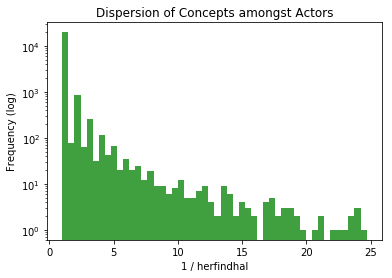

In [13]:
x = [concept_metrics[concept]['h'] for concept in concept_metrics]
x = [i for i in x if i < 25]

# the histogram of the data
n, bins, patches = plt.hist(x, 50, log=True, facecolor='green', alpha=0.75)

plt.xlabel('1 / herfindhal')
plt.ylabel('Frequency (log)')
plt.title('Dispersion of Concepts amongst Actors')

plt.show()

### Show Top Actors

In [14]:
for t in sorted_sayers[:21]:
    syn_id = t[0]
    if syn_id:
        print('%s %s %s %s' % (syn_id, mer.synonym_label(syn_id), t[1], len(concepts_by_sayer[syn_id])))

2639205 {russia} 266 1161
134 {korea, (+ north korea)} 135 507
2639483 {putin} 128 541
2638657 {iran} 128 460
2638503 {turkey} 100 472
322 {(+ pope francis), francis, pope} 79 351
2638654 {ukraine} 79 298
2639270 {france} 59 262
2641341 {erdogan} 57 236
920 {(+ david cameron), cameron, david} 56 226
2652235 {pentagon} 56 260
472 {(+ saudi arabia), saudi, arabia} 55 259
2638372 {syria} 53 199
2643138 {kerry} 52 214
507 {kremlin, (+ the kremlin)} 49 245
2638559 {pakistan} 48 197
54 {angela, merkel, (+ angela merkel)} 46 215
2638454 {germany} 44 246
2638467 {eu} 40 181
2638636 {japan} 40 175


### Concepts by actor

In [18]:
concepts = concepts_by_sayer[134]

sorted_concepts = sorted(concepts.items(), key=operator.itemgetter(1), reverse=True)
for t in sorted_concepts[:21]:
    syn_id = t[0]
    if syn_id:
        print('[%s] %s %s %s' % (syn_id, mer.synonym_label(syn_id, short=False), t[1], concept_metrics[syn_id]['h']))

[2638715] {missile} 19 9.102362204724404
[20] {(+ the u.s), u.s} 10 28.508474576271112
[134] {korea, (+ north korea)} 7 31.970168612191955
[989] {(+ ballistic missile), ballistic} 7 3.755555555555556
[2644190] {kim} 6 10.88059701492538
[1598] {(+ jong un), jong} 6 9.965517241379311
[107093] {(+ hostile acts’), (+ it has_arrested (+ a (+ virginia (+ for student (+ hostile acts’))))), (+ a (+ virginia (+ for student (+ hostile acts’)))), (+ for student (+ hostile acts’)), (+ broad (+ ‘ (+ terrorist (+ acts’ list)))), (+ terrorist (+ acts’ list)), acts’, (+ acts’ list), (+ ‘ (+ terrorist (+ acts’ list))), (+ virginia (+ for student (+ hostile acts’)))} 6 1.0
[1987264] {(+ joint (+ industrial zone)), (+ industrial zone)} 5 1.0
[2639728] {(+ nuclear test)} 5 2.1333333333333333
[4554] {declaration, (+ of declaration war), (+ a (+ of declaration war))} 5 2.7777777777777772
[2326389] {(+ no (+ to ties (+ rogue (+ ship nytimes.com)))), (+ to ties (+ rogue (+ ship nytimes.com))), (+ ship nytimes

### Concepts by actor and $1/herfindhal$

In [17]:
ego = 1221043
concepts = concepts_by_sayer[ego]

concepts_by_h = {}
for concept in concepts:
    h = int(round(concept_metrics[concept]['h']))
    if h not in concepts_by_h:
        concepts_by_h[h] = []
    concepts_by_h[h].append(concept)

for syn_id in concepts_by_h[4][:20]:
    actors = [mer.synonym_label(actor, short=True) for actor in actors_for_concept(syn_id) if actor != ego]
    actor_str = ', '.join(actors)
    print('[%s] %s %s %s {%s}' % (syn_id, mer.synonym_label(syn_id, short=True), concept_metrics[syn_id]['h'], concept_metrics[syn_id]['total'], actor_str))

[987] new york 4.0 4 {ukraine, iraq pm, belgium}
[1220458] hackers 4.5 6 {a new report, cybersecurity firm, vodafone, yahoo}
[1220267] spies 4.0 4 {putin, norway, sweden}
[1220437] poland 3.571428571428571 5 {britain, putin, defense minister}
[1222383] foreign minister 3.571428571428571 5 {iranian mp, iraq, iranian fm}
[5357] armenian genocide 4.0 4 {turkey, watch human rights, erdoğan}
[1230107] jordan 3.571428571428571 5 {syrian government, japan, the syrian army}
[1222061] in ukraine 4.499999999999999 6 {angela merkel, kiev, osce, george soros}
[16] the cia 4.5 6 {european court, wikileaks, german government, pakistan court}
[1271329] patience 3.571428571428571 5 {turkey, germany, trump}
[1243094] with u.s 4.499999999999999 6 {iran, khamenei, germany, 's lavrov russia}
[1223876] diplomatic 4.0 4 {the kremlin, turkey, russian official}
[1227262] commander 4.0 4 {hezbollah, iraqi military, iraq}
[1996] the brink 3.571428571428571 5 {north korea, france, putin}
[2056] zika virus 4.0 4 

### Alignment on concepts

In [ ]:
ego = 845         # the pope
concept = 959230  # contraception

def related_concepts(actor, concept):
    result = set()
    for claim in sayers_and_claims[actor]:
        claim_concepts = concepts_in_claim(claim)
        if concept in claim_concepts:
            for c in claim_concepts:
                if c != concept:
                    result.add(c)
    return result

actors = actors_for_concept(concept)

for actor in actors:
    actor_name = mer.synonym_label(actor, short=True)
    print('ACTOR: %s' % actor_name)
    related = related_concepts(actor, concept)
    for rel in related:
        print(mer.synonym_label(rel, short=True))

### Who talks about what - Ego Graph

In [ ]:
ego = 845
who_what = {}

concepts = concepts_by_sayer[ego]

nodes = set()

def add_edge(orig, targ, weight):
    if orig and targ:
        if orig not in who_what:
            who_what[orig] = {}
        who_what[orig][targ] = weight
        nodes.add(orig)
        nodes.add(targ)

for concept in concepts:
    if len(concept_actor[concept]) > 1:
        for actor in concept_actor[concept]:
            add_edge(actor, concept, concept_actor[concept][actor])
        
file = open('../who_what.gml', 'w')
file.write('graph\n[\n')
for node in nodes:
    file.write('node\n[\nid %s\nlabel "%s"\n]\n' % (str(node), mer.synonym_label(node, short=True)))
for orig in who_what:
    for targ in who_what[orig]:
        w = who_what[orig][targ]
        file.write('edge\n[\nsource %s\ntarget %s\nweight %s\n]\n' % (str(orig), str(targ), str(w)))
file.write(']\n')
file.close()

In [ ]:
ego = 900574

concepts = concepts_by_sayer[ego]

file = open('../france.csv', 'w')
file.write('concept,herfindahl,total,ego_total,actors\n')
for concept in concepts:
    file.write('%s,%s,%s,%s,' % (mer.synonym_label(concept, short=True),
                                 concept_metrics[concept]['h'],
                                 concept_metrics[concept]['total'],
                                 concept_actor[concept][ego]))
    actor_str = '|'.join([mer.synonym_label(actor, short=True) for actor in concept_actor[concept] if actor != ego])
    file.write('%s\n' % actor_str)
file.write('\n')
file.close()

In [ ]:
print(mer.synonym_label(908171))
print(mer.syn_id('(+ pope francis)'))

### Concept proximity

In [18]:
hs = HyperSimilarity(hg)

global_economy = mer.syn_id('(+ global economy)')
financial_crisis = mer.syn_id('(+ financial crisis)')
catholic_church = mer.syn_id('(+ catholic church)')
pope_francis = mer.syn_id('(+ pope francis)')
hackers = mer.syn_id('hackers')
spies = mer.syn_id('spies')

# mer.synonym_full_edges(c4)

hs.synonym_similarity(mer, hackers, spies)

1.0056965782477258

In [ ]:
used_concepts = set()

for sayer in sayers_and_claims:
    used_concepts = used_concepts.union(concepts_by_sayer[sayer])

used_concepts = list(used_concepts)
    
print(len(used_concepts))

In [ ]:
random.seed()

def random_concept():
    return random.choice(used_concepts)

x = []
best_prox = -1.
best_pair = None
for i in range(1000):
    c1 = random_concept()
    c2 = random_concept()
    hs = HyperSimilarity(hg)
    prox = hs.synonym_similarity(mer, c1, c2)
    x.append(prox)
    if prox > best_prox:
        best_prox = prox
        best_pair = (c1, c2)
        print('%s | %s => %s' % (mer.synonym_label(best_pair[0], short=True), mer.synonym_label(best_pair[1], short=True), best_prox))

In [17]:
def related_concepts(main_concept, actor):
    concepts = set()
    for claim in sayers_and_claims[actor]:
        claim_concepts = concepts_in_claim(claim)
        if main_concept in claim_concepts:
            for concept in claim_concepts:
                if concept != main_concept:
                    concepts.add(concept)
    return concepts

# main_concept = mer.syn_id('cia')
# main_concept = mer.syn_id('fifa')
main_concept = mer.syn_id('hackers')
actors = actors_for_concept(main_concept)

related_concepts_by_actor = {}
for actor in actors:
    related_concepts_by_actor[actor] = related_concepts(main_concept, actor)
    
for actor in related_concepts_by_actor:
    print('ACTOR %s' % mer.synonym_label(actor, short=True))
    for concept in related_concepts_by_actor[actor]:
        print('-> %s' % mer.synonym_label(concept, short=True))

ACTOR new report
-> russian hackers
-> of version microsoft windows
-> used_to russian hackers flaw in microsoft windows spy on nato
-> russian
-> on nato
-> nato
-> flaw in microsoft windows
-> in microsoft windows
ACTOR putin
-> russian
-> russian hackers
-> private russian hackers
ACTOR 's defence ministry china
-> us hackers
ACTOR noaa
-> of breached four by chinese hackers its websites
-> breached four by chinese hackers
-> chinese hackers
-> chinese
-> its websites
ACTOR at hunter 's largest cybersecurity firm russia
-> chinese hackers
-> chinese
-> us chinese hackers
ACTOR in article the wall street journal
-> cyber attack
-> citizen ’s arrest
-> has_label – us –_us
-> of focus recent in surge cyber attacks that could_be_linked to iranian ’s arrest american
-> chinese
-> recent in surge cyber attacks
-> that could_be_linked to iranian ’s arrest american
-> to iranian ’s arrest american
-> appear – us target obama administration accounts iran military hackers working officials on

TypeError: 'int' object is not subscriptable

In [20]:
hs = HyperSimilarity(hg)

def closest_concept(orig_set, targ_set):
    best_prox = -1.
    best_pair = None
    for orig in orig_set:
        for targ in targ_set:
            prox = hs.synonym_similarity(mer, orig, targ)
            if prox > best_prox:
                best_prox = prox
                best_pair = (orig, targ)
    return best_pair, best_prox

nodes = {}
edges = []
for actor in related_concepts_by_actor:
    nodes[actor] = {'type': 'actor'}
for actor_orig in related_concepts_by_actor:
    best_prox = -1.
    best_pair = None
    for actor_targ in related_concepts_by_actor:
        if actor_orig != actor_targ:
            pair, prox = closest_concept(related_concepts_by_actor[actor_orig], related_concepts_by_actor[actor_targ])
            if prox > best_prox:
                best_prox = prox
                best_pair = pair
            pair, prox = closest_concept(related_concepts_by_actor[actor_orig], {actor_targ})
            if prox > best_prox:
                best_prox = prox
                best_pair = pair
    concept = best_pair[1]
    if concept not in related_concepts_by_actor:
        nodes[concept] = {'type': 'concept'}
    edges.append((actor_orig, concept))
    print('%s -> %s [%s]' % (mer.synonym_label(actor_orig, short=True), mer.synonym_label(concept, short=True), best_prox))

new report -> russian [3759.6564149388964]
putin -> russian [3759.6564149388964]
's defence ministry china -> iran [0.44451117516218647]
noaa -> chinese [2025.0299948391785]
at hunter 's largest cybersecurity firm russia -> chinese [2025.0299948391785]
in article the wall street journal -> chinese [2025.0299948391785]
vodafone -> iran [74.04284835738136]
yahoo -> cyber attack [308.26321139407975]


In [19]:
G = nx.DiGraph()
for node in nodes:
    G.add_node(node)
for edge in edges:
    G.add_edge(edge[0], edge[1])
gnodes = G.nodes()
gedges = G.edges()

pos = nx.spring_layout(G)

def node_shape(n):
    if nodes[n]['type'] != 'actor':
        return 'square'
    else:
        return 'triangle'
    
def node_color(n):
    if nodes[n]['type'] != 'actor':
        return '#8A2BE2'
    else:
        return '#FFA500'

nodes_dict = [{'id': mer.synonym_label(n, short=True),
               'color': node_color(n),
               'node_shape': node_shape(n),
               'x': pos[n][0] * 1000,
               'y': pos[n][1] * 1000} for n in gnodes]
node_map = dict(zip(nodes,range(len(gnodes))))  # map to indices for source/target in edges

edges_dict = [{'source': node_map[gedges[i][0]],
               'target': node_map[gedges[i][1]],
               'color':'#A0A0A0'} for i in range(len(gedges))]

visJS_module.visjs_network(nodes_dict, edges_dict,
                           node_size_multiplier=7,
                           node_size_transform = '',
                           node_font_color = '#303030',
                           node_font_background = 'rgba(255, 255, 255, .5)',
                           node_font_size=25,
                           edge_arrow_to=True,
                           physics_enabled=True,
                           edge_color_highlight='#8A324E',
                           edge_color_hover='#8BADD3',
                           edge_width=3,
                           max_velocity=15,
                           min_velocity=1)

NameError: name 'nodes' is not defined

## SemBubbles

In [33]:
json = {'actors': {}, 'concepts': {}, 'aa': {}, 'ac': {}, 'ca': {}, 'cc': {}}

actors = set([sayer for sayer in sayers if sayer and len(sayers_and_claims[sayer]) > 2])

# actors, concepts & aa
for actor_id in actors:
    actor = mer.synonym_label(actor_id, short=True)
    json['actors'][actor] = {'frequency': len(sayers_and_claims[actor_id]),
                             'name': actor}
    json['aa'][actor] = {}
    for concept_id in concepts_by_sayer[actor_id]:
        concept = mer.synonym_label(concept_id, short=True)
        # concept is actor
        if concept_id in actors:
            actor2 = concept
            if actor2 not in json['aa'][actor]:
                json['aa'][actor][actor2] = 0
            json['aa'][actor][actor2] += 1
        # concept is concept
        else:
            if concept not in json['concepts']:
                json['concepts'][concept] = {'frequency': 0,
                                             'name': concept}
            json['concepts'][concept]['frequency'] += 1

# filter low freq concepts
new_concepts = {}
for concept in json['concepts']:
    if json['concepts'][concept]['frequency'] > 1:
        new_concepts[concept] = json['concepts'][concept]
json['concepts'] = new_concepts

# ac, ca, init cc
for actor_id in actors:
    actor = mer.synonym_label(actor_id, short=True)
    json['ac'][actor] = {}
    for concept_id in concepts_by_sayer[actor_id]:
        concept = mer.synonym_label(concept_id, short=True)
        if concept in json['concepts'] and concept not in actors:
            if concept not in json['ca']:
                json['ca'][concept] = {}
                json['cc'][concept] = {}
            if actor not in json['ca'][concept]:
                json['ca'][concept][actor] = 0
            json['ca'][concept][actor] += 1
            if concept not in json['ac'][actor]:
                json['ac'][actor][concept] = 0
            json['ac'][actor][concept] += 1

# cc
for actor in actors:
    for claim in sayers_and_claims[actor]:
        claim_concepts = [mer.synonym_label(concept, short=True) for concept in concepts_in_claim(claim)]
        claim_concepts = set([concept for concept in claim_concepts if concept in json['concepts']])
        combs = itertools.combinations(claim_concepts, 2)
        for comb in combs:
            c1 = comb[0]
            c2 = comb[1]
            if c2 not in json['cc'][c1]:
                json['cc'][c1][c2] = 0
            if c1 not in json['cc'][c2]:
                json['cc'][c2][c1] = 0
            json['cc'][c1][c2] += 1
            json['cc'][c2][c1] += 1

with open('../reddit-worldnews-sembubble.json', 'w') as json_file:
    json_file.write(j.dumps(json))

print('actors: %s; concepts: %s; %s' % (len(actors), len(json['concepts']), len(json['ca'])))

actors: 350; concepts: 824; 824


In [48]:
print('actors: %s; concepts: %s; %s' % (len(json['actors']), len(json['concepts']), len(json['aa'])))

actors: 349; concepts: 824; 349
